In [1]:
import numpy as np
import math
import pandas as pd
import scipy.spatial.distance as dis
import matplotlib.pyplot as plt
import numpy.random as rand
import scipy.stats as stats
import scipy.misc as misc
import scipy.special as special
import scipy.spatial.distance as dis
from collections import Counter
import seaborn as sns

In [2]:
! wget -o - "http://mcb112.org/w12/w12-data.tbl" > log.log

In this project, I cluster RNA-seq data first using k-means clustering, and then using principle component analysis

In [3]:
#Get the data and read into dataframe
with open('w12-data.tbl', 'r') as f:
    data = pd.read_table(f, delim_whitespace=True)

Performs k-means clustering

In [15]:
#takes in data and centroids, calculates the minimum distance between each point and each center, and then assigns each point to the closest centroid. 
#These functions are inspired by the code from section

def assign(points, centers):
    distances = []
    clusters = []
    for i in range(len(points)):
        #calculates Euclidean distance between all points and centroids, then assigns to the cluster with the lowest distance 
        temp_dist = np.min([np.linalg.norm(points[i] - center) for center in centers])
        temp_cluster = np.argmin([np.linalg.norm(points[i] - center) for center in centers])
        #temp_dist = np.min([dis.euclidean(points[i],center) for center in centers])
        #temp_cluster = np.argmin([dis.euclidean(points[i],center) for center in centers])
        distances.append(temp_dist)
        clusters.append(temp_cluster)
    
    distance = sum(distances)
 
    #counts number of clusters with nonzero values
    c = Counter(clusters)

    centers = dict.fromkeys([0, 1, 2, 3, 4, 5, 6, 7], 0)

    #check to see if clusters have zero points assigned to them
    for element in c:
        centers[element] = c[element]
    empties = []
    
    for key in centers:
        if centers[key] == 0:
            empties.append(key)
            
    #assign points with farthest distances to empty clusters (1 point per empty cluster)
    for x in empties:
        max_idx = np.argmax(distances)
        distances[max_idx] = 0
        clusters[max_idx] = x
    return clusters, distance

def update(points, clusters, num_clust):
    
    #updates centers by taking the average of distances between a centroid and each of its points 
    points = np.asarray(points)
    new_centers = []
    
    # Find indices of each point assigned to each cluster - from section notes
    new_clusters = ([np.where(np.asarray(clusters) == x) for x in range(num_clust)])
    
    # Average position of each point assigned to each cluster - from section notes
    new_centers = [np.mean(points[new_clusters[x]],0) for x in range(len(new_clusters))]
    
    return new_centers

In [16]:
points = np.array(data)

In [17]:
#finding random initial starting centroids based on how many clusters we want, the number of genes, and the upper limit
def get_initial_centroids(num_clusts, gene_number, limit):
    init_centroids = []
    for i in range(num_clusts):
        temp = np.random.randint(limit, size = gene_number)
        init_centroids.append(temp)
    return (init_centroids)

In the following lines, I run the kmeans algorithm by starting with random centroids, running the assign/update steps until the clusters converge, then repeat the process with 100 more starting conditions to try to get close to the global optimum. Further, since there is a Gaussian assumption in this process and our data is lognormally distributed, I run the algorithm on the log expression of our data. 

In [23]:
#This process was inspired by the code we used in section

num_clusts = 8
num_iterations = 50
gene_number = 2001
min_dist = float('inf')
limit = data.values.max()

best_centers = []
best_clusters = []

log_points = np.log(points)

for i in range(num_iterations):
    
    #gets new starting condition
    centers = get_initial_centroids(num_clusts, gene_number, np.log(limit))
    last_clusters = [1] * len(points)
    clusters = [0] * len(points)
    
    #update until the clusertings don't change
    while last_clusters != clusters: 

        last_clusters = clusters

        #assigns points to new centers
        clusters, distance = assign(log_points, centers)
        
        #takes average of distances, finds new centers
        centers = update(log_points, clusters, num_clusts)

    #Stores best distance, centers, and clusterings
    if distance < min_dist:
        min_dist = distance
        best_centers = centers
        best_clusters = clusters
        #This allows us to watch the minimum distance decrease to keep us entertained while the program is running :) 
        print("mindist", min_dist)

mindist 4145.202238738407
mindist 4138.276355968295
mindist 4137.439134785115


/Users/IsaacSebenius/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/IsaacSebenius/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [24]:
print("The lowest total distance achieved using this k means method is %.1f" %(min_dist))

The lowest total distance achieved using this k means method is 4137.4. This is comparable to Watson's value.


In [1]:
Now, I approach the same problem using PCA.

SyntaxError: invalid syntax (<ipython-input-1-10f222f72364>, line 1)

In [25]:
#Gets log of data
new_data = pd.DataFrame(points)
new_log_data = pd.DataFrame(log_points)
new_data.columns = data.columns
new_log_data.columns = data.columns

#From every cell, subtracts the mean of its column to center the data
for column in new_data.columns:
    new_data[column] = new_data[column] - new_data[column].mean()
    new_log_data[column] = new_log_data[column] - new_log_data[column].mean()


Next, I perform SVD on my logged data. It makes sense to do this process on the log of the data because implicit in doing PCA with SVD is an assumption of Gaussian distributed variance, which only occurs once we take the log of the data. Thus in order to correctly find the principal components, we should first take the log of the counts.

In [26]:
#perform SVD
U, s, Wt = np.linalg.svd(new_log_data, full_matrices = False)

In [27]:
#Get first two principal components
W_q = Wt[0:2].transpose()


I find the projection of our data into 2 dimensions in the following line.

In [28]:
Y_q = new_log_data @ W_q

Here, I visualize the 200 cells in 2D space using the first two principal components

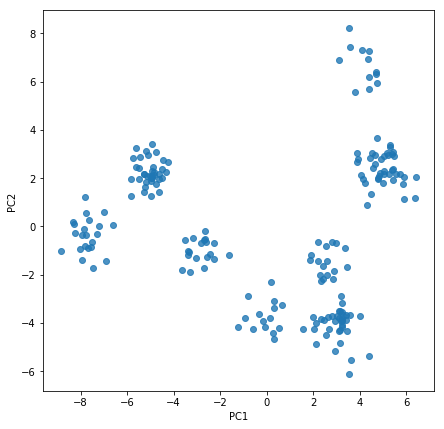

In [29]:
fig, ax = plt.subplots(1, figsize=(7,7))
plot = sns.regplot(x = Y_q[0], y = Y_q[1], fit_reg = False);
plot.set(xlabel = "PC1", ylabel = "PC2");

From this projection into 3D space, it does indeed look like Watson was correct to expect 8 clusters. However, in order to confirm that these are the best and only clusters we can find form the data, we should analyze the eigenvalues of the principal components used to ensure that using additional principal components wouldn't result in finding additional patterns in the data.

Here, I find the lambda matrix and get the eigenvalues for my PCA by squaring S and dividing by n-1. Then, I compute the total variance by summing over the trace of Lamdba.

In [30]:
S = np.diag(s)
Lambda = (S@S)/(200-1)
Lambda.shape

Lambda_vector = (s*s)/(200-1)

total_variance = np.sum(Lambda_vector)

Here, I get the eigenvalues from the negative control, where are no cell types and no correlations between genes.

In [31]:
! wget -o - "http://mcb112.org/w12/w12-eigen.tbl" > log.log
with open('w12-eigen.tbl', 'r') as f:
    neg_eigen = pd.read_table(f, delim_whitespace=True, header = None)

total_neg_variance = np.sum(neg_eigen[1])

Next, I plot the eigenvalues of the real data against the eigenvalues for the negative control data to get a sense of how many principal components are important.

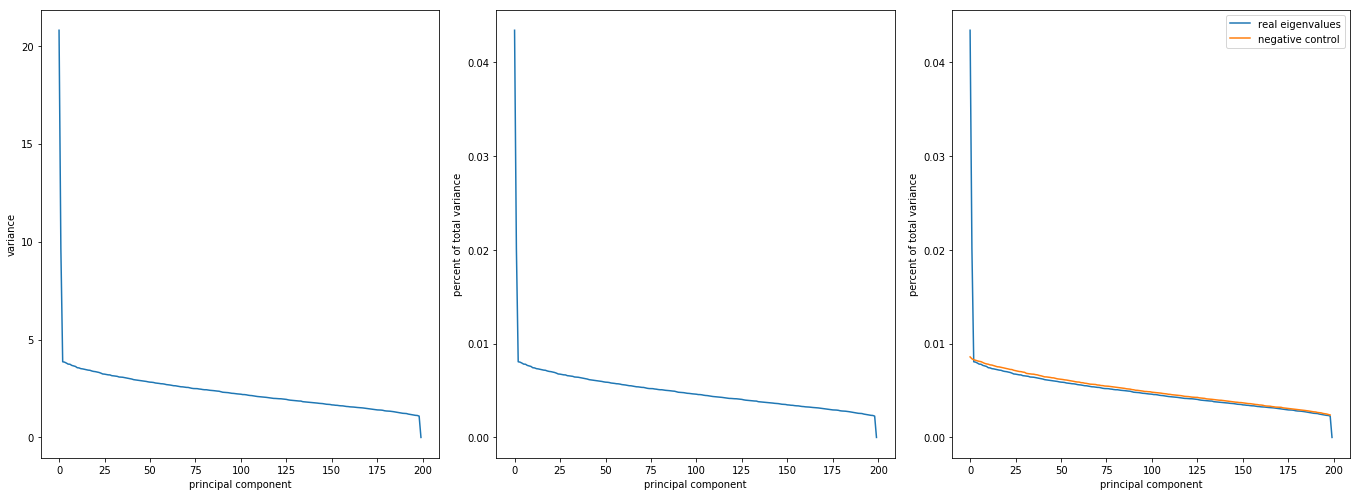

In [36]:
fig, ax = plt.subplots(1,3, figsize=(19,7))
ax[0].plot(Lambda_vector)
ax[0].set(xlabel = "principal component", ylabel = "variance")

ax[1].plot(Lambda_vector/total_variance)
ax[1].set(xlabel = "principal component", ylabel = "percent of total variance")

ax[2].plot(Lambda_vector/total_variance, label = "real eigenvalues")
ax[2].plot(neg_eigen.index, neg_eigen[1]/total_neg_variance, label = "negative control")
ax[2].set(xlabel = "principal component", ylabel = "percent of total variance")

ax[2].legend()
plt.tight_layout()

As we can see from the graphs above, there only seem to be a small number of principal components whose eigenvalues contribute to overall variance significantly more than those from the negative control. In the next line, I find exactly how many PCs from the real data contribute more to the percent of total variance than from the negative control

In [37]:
#Find where percent of variance is better than negative control
np.where(Lambda_vector[0:199]/total_variance - neg_eigen[1]/total_neg_variance > 0)

(array([0, 1]),)

This shows that only the first two principal components contribute more to the percent of total variation than in the negative control. This means that even if we were to use more than two principal components, we would not be likely to find any other meaningful clusters because, even though we would be capturing more of total variance, the contribution from any successive principal components would be no more significant than that achieved from randomly plotted points. Thus, this confirms that using the first two principal components is a good way to find any meaningful clustering.

Having established that using the first two principal components is sufficient, we want to find how many genes actually contribute to cell type identity. We can do so by examining the loadings, and finding which genes significanly contribute to the loadings (eigenvectors) that correspond to the first two PC's. The more a particular gene contributes to its eigenvector, the more likely it is to contribute to cell identity. To determin what 'significant contribution' means, we can visually inspect, as in the graph below, the distribution of the contribution of each gene in the two first PC's and find a threshold that seems appropriate.

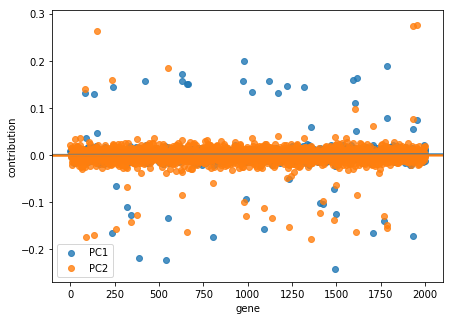

In [38]:
x = []
x.append(list(range(2001)))
x.append(list(range(2001)))

y = []
y.append(list(Wt[0]))
y.append(list(Wt[1]))

fig, ax = plt.subplots(1, figsize=(7,5))
plot = sns.regplot(x=np.array(x[0]), y=np.array(y[0]), label = "PC1");
plot = sns.regplot(x=np.array(x[1]), y=np.array(y[1]), label = "PC2");
plot.legend();
plot.set(xlabel = "gene", ylabel = "contribution");


By eye, it seems that a threshold of 0.05 distance from the origin would be appropriate in determining significant contribution from each gene. We can visualize which genes this would capture in the following plot.

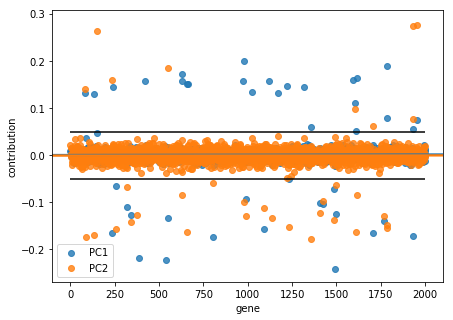

In [39]:
fig, ax = plt.subplots(1, figsize=(7,5))
plot = sns.regplot(x=np.array(x[0]), y=np.array(y[0]), label = "PC1");
plot = sns.regplot(x=np.array(x[1]), y=np.array(y[1]), label = "PC2");
plot.set(xlabel = "gene", ylabel = "contribution")
plot.legend()
plot.hlines([-0.05,0.05], 0,2000);

Next, I find how many genes actually pass this threshold and contribute to cell identity.

In [40]:
gene_count = 0
genes = []

for i in range(2):
    for j, k in enumerate(list(Wt[i])):
        #print(k)
        if (np.abs(k)>0.05) and (j not in genes):
            gene_count += 1
            genes.append(j)

In [41]:
print("About %i genes contribute to cell identity, according to a threshold of 0.05." %(gene_count))

About 47 genes contribute to cell identity, according to a threshold of 0.05.


# Problem 3

In the plot below, I color the cells according to their clustering as attained in part 1.

Text(0,0.5,'PC2')

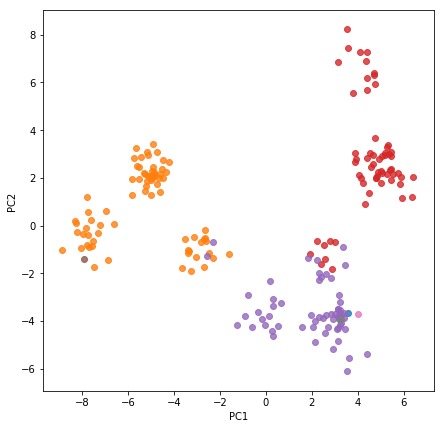

In [42]:
fig, ax = plt.subplots(1, figsize=(7,7))
clusters_idxs = [np.where(np.asarray(best_clusters) == x) for x in range(num_clusts)]
for i in range(num_clusts):
    sns.regplot(x = Y_q[0][list(clusters_idxs[i][0])], y = Y_q[1][list(clusters_idxs[i][0])], fit_reg = False)
plt.xlabel("PC1")
plt.ylabel("PC2")

Clearly, the clusterings achieved using the kmeans from part 1 are not correct. We can explain this by considering how this kmeans works and how our data are situated in 2001 dimensional space. In part 1, we simply calculated the euclidean distance between each point and its centroid, which took into account the distance from all 2001 dimensions. Given that we found that we only need the first two principal components to get any significnat clustering, when we did the kmeans algorithm, the signal from the two principal components that matter was completely overwhelmed by the noise coming from the rest of the principal components. In fact, as we can see from our graph above, the combination of the first two PCA's only account for less than ten percent of the total variance, so it would be very difficult for an algorithm which takes into account all principal components to parse signal from noise.

However, now that we have established that we can find the meaningful clusterings only using the first two principal components, one way we can remedy this is to run kmeans using PC scores. That is, we can project the data onto a 2-dimensional space using the first two principal components, and only then run kmeans - this should allow the algorithm to find the meaningful clustering from these components without getting overwhelmed by the noise from all other dimensions. I do this below:

In [43]:
new_k_data = pd.DataFrame(Y_q)
new_k_data = new_k_data.transpose()

This time, when I run the k means algorithm, instead of predefining a set number of iterations to run, I run the algorithm with as many starting configurations as it takes in order for the minimum distance to drop below 150. This is because at times, even 100 starting configurations were not enough to achieve consistent perfect clustering, and I noticed that every time the minimum distance fropped below this threshold of 150, the clustering looked ideal. 

In [44]:
#Run kmeans on the projection of our data into 2 dimensions

num_clusts = 8
num_iterations = 100
num_genes = 2
min_dist = float('inf')
limit = new_k_data.values.max()

best_centers = []
best_clusters = []

#for i in range(num_iterations):
while min_dist > 150:
    #chooses centroid values as random choices from the data points

    centers = get_initial_centroids(num_clusts, num_genes, limit)
    last_clusters = [1] * len(Y_q)
    clusters = [0] * len(Y_q)
    
    #update until the clusertings don't change
    while last_clusters != clusters: 

        last_clusters = clusters

        clusters, distance = assign(np.array(Y_q), centers)

        centers = update(np.array(Y_q), clusters, num_clusts)
        
    #Stores best distance, centers, and clusterings
    if distance < min_dist:
        min_dist = distance
        best_centers = centers
        best_clusters = clusters
    
        #This allows us to watch the minimum distance decrease to keep us entertained while the program is running :) 
        print('mindist', min_dist)


mindist 262.48874279032276
mindist 196.89516438055028
mindist 172.16157639604123
mindist 171.84156269235655
mindist 171.0252891272147
mindist 170.5708848457001
mindist 168.72187495923055
mindist 142.4279009726577


Below, I plot the clusterings as achieved by this new k means approach.

Text(0,0.5,'PC2')

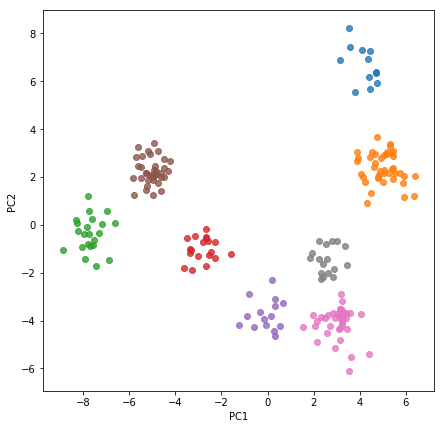

In [52]:
fig, ax = plt.subplots(1, figsize=(7,7))
clusters_idxs = [np.where(np.asarray(best_clusters) == x) for x in range(num_clusts)]
for i in range(num_clusts):
    sns.regplot(x = Y_q[0][list(clusters_idxs[i][0])], y = Y_q[1][list(clusters_idxs[i][0])], fit_reg = False)
plt.xlabel("PC1")
plt.ylabel("PC2")

As we can see, this new clustering method worked better. Clearly, this means that once the algorithm did not have to calculate euclidean distance in all dimensions, it was able to find the meaningful clusters in a much more effective way.

# Problem 4

Now, I aim to denoise and reconstruct the data by projecting it onto its two principal axes, then rotating it back to the original frame of reference. First, I get a diagonal 2x2 S_q matrix containing the values that are corresponding to the first to PC's, then get the first two columns of U to get U_q, and finally get the eigenvectors correponding to the first two PC's by finding the first two rows of Wt and transposing them to get W_q. Multiplying these together achieves our reconstructed data set, projected to the first to PC's and rotated back to the original frame of reference.

In [46]:
#Get 2x2 S_q matrix
S_cut = np.diag(s[0:2])
Lambda_cut = (S_cut@S_cut)/(200-1)

In [47]:
#Get U_q matrix with q = 2
u = pd.DataFrame(U)
U_q = []
U_q.append(np.array(u[0]))
U_q.append(np.array(u[1]))
U_q = np.transpose(U_q)


In [48]:
#Reconstruct data
X_q = U_q@S_cut@W_q.transpose()
X_q.shape

(200, 2001)

Next, I reorder the reconstructed data according to the clustering achieved in part 3. This will allow us to visualize the clusterings clearly in a heatmap.

In [49]:
reconstructed = pd.DataFrame(X_q)

indexes = []

for element in clusters_idxs:
    for x in list(element[0]):
        indexes.append(x)

reconstructed = reconstructed.reindex(indexes)


In [50]:
lines = []
total = 0
for element in clusters_idxs:
    lines.append(total + len(element[0]))
    total += len(element[0])

Finally, I plot the reordered, reconstructed data in a heatmap.

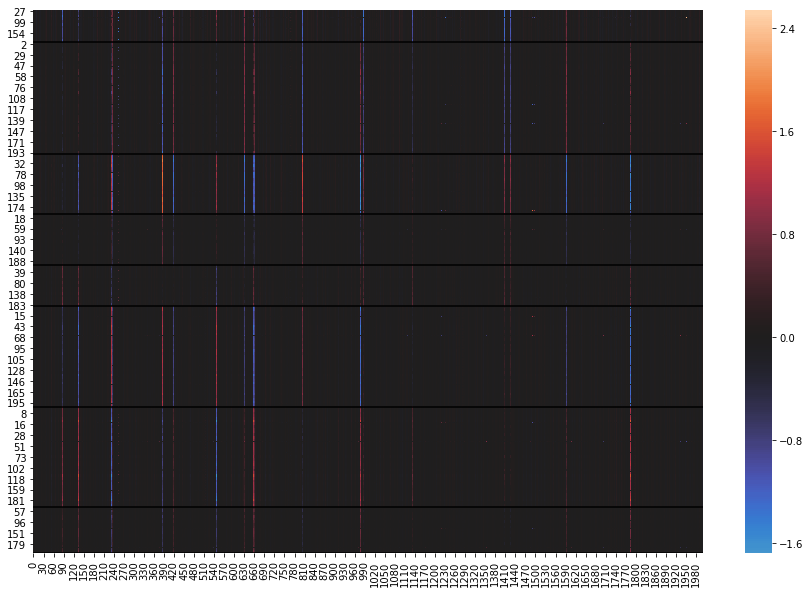

In [51]:
fig, ax = plt.subplots(1, figsize = (15, 10))
ax = sns.heatmap(reconstructed, center=0);
ax.hlines(lines, 0, 2000);

These clusterings, as we can see in the heatmap above, are very clearly delineated - much more so than in the original heatmap offered by Watson. This makes sense for a similar reason to why the k means algorithm worked much better in problem 3 than in problem 1. That is, in the original heatmap, the clustering was based off of k means which took into account the contribution of variance from all 2001 dimensions and all principal components. This means that the contribution of the Gaussian noise from all principal components overwhelmed any intelligible clustering patterns that have become apparent when only considering the first two. By reconstruct the data, since we only take into account the contribution of the first two principal components, we effectively denoise the expression heatmap. From this, as we see in the heatmap above, we are able to much more clearly detect delineated clustering. 